In [6]:
# Imports
import os
import numpy as np
from skimage import color
from skimage import io
import matplotlib.pyplot as plt
import pandas as pd

# Imports Model
import keras
import keras.backend as K
import tensorflow as tf
from keras.layers import Input, Conv2D, BatchNormalization, UpSampling2D
from keras.models import Model
from keras.regularizers import l2
from keras.utils import multi_gpu_model
from keras.utils import plot_model

# Create Training Data Set

In [10]:
g_img_rows = 256
g_img_cols = 256
g_kernel = 3
g_num_classes = 313

In [11]:
def is_gray(img):
    if len(img.shape) < 3: return True
    if img.shape[2]  == 1: return True
    b,g,r = img[:,:,0], img[:,:,1], img[:,:,2]
    if (b==g).all() and (b==r).all(): return True
    return False

In [16]:
folder_name_train_dataset = os.path.join(os.getcwd(), 'Places365\\train_256_100\\')
# print(folder_name_train_dataset)
entries = os.listdir(folder_name_train_dataset)
# print(entries)

# Load images
train_images_l = []  # X
train_images_ab = [] # Y
for file_name in entries:
    abs_file_name = os.path.join(folder_name_train_dataset, file_name)
#     print(abs_file_name)
    if(os.path.isfile(abs_file_name)):
        # Load original RGB image
        img_rgb = io.imread(abs_file_name)
#         print("img_rgb {}".format(img_rgb))

        # Skip if is gray
        if is_gray(img_rgb):
#             print(abs_file_name)
            continue

        # Convert RGB to L*a*b
        img_lab = color.rgb2lab(img_rgb)
        
        # Extract the L - luminance
        img_l = img_lab[:,:, 0]
        
        # Append to the train array
        train_images_l.append(img_l)
        
        # Extract the ab
        img_ab = img_lab[:,:, 1:]
        train_images_ab.append(img_ab)

# print(train_images_l)
# print(train_images_ab)

# Convert from list to np.array
x_df = np.asarray(train_images_l)
x_df = x_df.reshape(x_df.shape[0], x_df.shape[1], x_df.shape[2], 1)
y_df = np.asarray(train_images_ab)
print(x_df.shape)
print(y_df.shape)    

(95, 256, 256, 1)
(95, 256, 256, 2)


In [ ]:
# Create the Q = 313 bins of colors for y


# Create Model

In [4]:
l2_reg = l2(1e-3)

input_tensor = Input(shape=(g_img_rows, g_img_cols, 1))
x = Conv2D(64, (g_kernel, g_kernel), activation='relu', padding='same', name='conv1_1', kernel_initializer='he_normal', 
           kernel_regularizer=l2_reg)(input_tensor)
x = Conv2D(64, (g_kernel, g_kernel), activation='relu', padding='same', name='conv1_2', kernel_initializer='he_normal', 
           kernel_regularizer=l2_reg, strides=(2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(128, (g_kernel, g_kernel), activation='relu', padding='same', name='conv2_1', kernel_initializer="he_normal",
           kernel_regularizer=l2_reg)(x)
x = Conv2D(128, (g_kernel, g_kernel), activation='relu', padding='same', name='conv2_2', kernel_initializer="he_normal",
           kernel_regularizer=l2_reg, strides=(2, 2))(x)
x = BatchNormalization()(x)

outputs = Conv2D(g_num_classes, (1, 1), activation='softmax', padding='same', name='pred')(x)

model = Model(inputs=input_tensor, outputs=outputs, name="ColorNet")


In [7]:
sgd = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True, clipnorm=5.)
model.compile(optimizer=sgd, loss='categorical_crossentropy')

In [17]:
model.fit(x = x_df,
            y = y_df,
            epochs = 1)

ValueError: Error when checking target: expected pred to have shape (64, 64, 313) but got array with shape (256, 256, 2)

# Test - one image

C:\Users\denis\PycharmProjects\ImageColorization\Places365\train_256_100\Places365_val_00000001.jpg
H_orig = 256, W_orig = 256


(-0.5, 255.5, 255.5, -0.5)

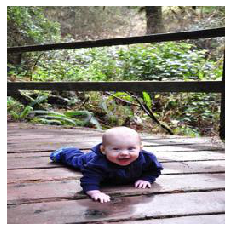

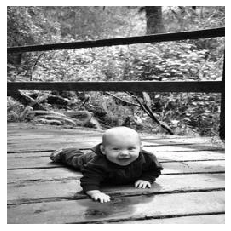

In [94]:
# Load original image
filename = os.path.join(os.getcwd(), 'Places365\\train_256_100\\Places365_val_00000001.jpg')
print(filename)
img_rgb = io.imread(filename)
(H_orig, W_orig) = img_rgb.shape[:2] # original image size
print('H_orig = {}, W_orig = {}'.format(H_orig, W_orig))
# print("img_rgb {}".format)

# Convert RGB to L*a*b
img_lab = color.rgb2lab(img_rgb)
# print("img_lab {}".format(img_lab))

# Extract the L - luminance
img_l = img_lab[:,:, 0]
# print("img_l {}".format(img_l))

# Make Grayscale
img_lab_bw = img_lab.copy()
img_lab_bw[:, :, 1:] = 0
# print("img_lab_bw {}".format(img_lab_bw))
img_rgb_bw = color.lab2rgb(img_lab_bw)
# (H_bw, W_bw) = img_rgb_bw.shape[:2] # original image size
# print('H_bw = {}, W_bw = {}'.format(H_bw, W_bw))
# print("img_rgb_bw {}".format(img_rgb_bw))

# Show original image, along with grayscale input
img_pad = np.ones((H_orig, int(W_orig/10), 3))
plt.figure(1)
plt.imshow(img_rgb)
plt.axis('off')
plt.figure(2)
plt.imshow(img_rgb_bw)
plt.axis('off')

In [79]:
# Create some dummy ab
ab = img_lab[:,:, 1:]

(-0.5, 255.5, 255.5, -0.5)

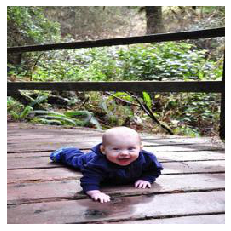

In [81]:
# Concatenate L with ab
img_lab_out = np.concatenate((img_l[:,:,np.newaxis], ab), axis=2)
img_rgb_out = color.lab2rgb(img_lab_out)
plt.imshow(img_rgb_out)
plt.axis('off')